<a href="https://colab.research.google.com/github/princ1211/MaskDetect/blob/main/Final_Model_tested.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os


In [ ]:

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Train Model- 

In [ ]:
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True,
	help="path to input dataset")
ap.add_argument("-p", "--plot", type=str, default="plot.png",
	help="path to output loss/accuracy plot")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to output face mask detector model")
args = vars(ap.parse_args())

Setting batch-size and epochs

In [ ]:
INIT_LR = 1e-4
EPOCHS = 50
BS = 32

In [ ]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
 
 print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

partition the data into training and testing splits using 75% of the data for training and the remaining 25% for testing

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False


In [ ]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


predIdxs = np.argmax(predIdxs, axis=1)


print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


print("[INFO] saving mask detector model...")
model.save(args["model"], save_format="h5")

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

2021-03-26 11:03:34.997086: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
[INFO] loading images...
2021-03-26 11:03:49.325186: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-26 11:03:49.326305: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-26 11:03:49.382497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-26 11:03:49.383082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-03-26 11:03:49.383136: I tensorflow/stream_executor/p

#**Predict on Single Image**

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...


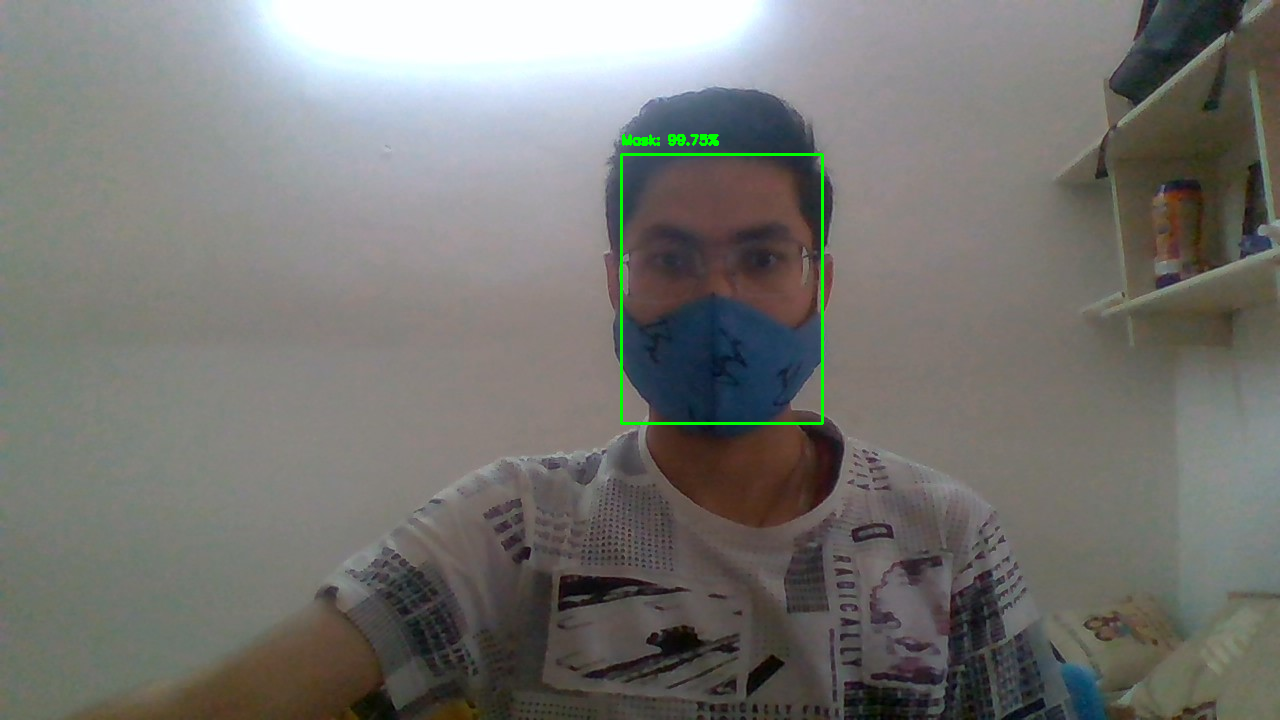

In [ ]:

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow
from natsort import natsorted, ns

input_file_path = "/content/drive/MyDrive/test2.jpg"
prototxtPath = "/content/drive/MyDrive/face_detector-master/face_detector/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/face_detector-master/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)
model = load_model("mask_detector.model")

def process_images(input_file_path):

	image = cv2.imread(input_file_path)

	(h, w) = image.shape[:2]

	# construct a blob from the image
	blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	print("[INFO] computing face detections...")
	net.setInput(blob)
	detections = net.forward()
	for i in range(0, detections.shape[2]):
		
		confidence = detections[0, 0, i, 2]
		if confidence > 0.5:

			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			face = image[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			#Check if mask or not
			(mask, withoutMask) = model.predict(face)[0]
			label = "Mask" if mask > withoutMask else "No Mask"
			color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

	
			label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
			cv2.putText(image, label, (startX, startY - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
			cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)


	save_path = input_file_path.split(".",1)

	cv2_imshow(image)

process_images(input_file_path)

#**Predict Using Video frames**

In [ ]:

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
from imutils.video import FPS

from google.colab.patches import cv2_imshow
import pdb

#Input video file path
input_video_path = "/content/drive/MyDrive/WIN_20210326_16_56_15_Pro.mp4"

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		preds = maskNet.predict(faces)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = "/content/drive/MyDrive/face_detector-master/face_detector/deploy.prototxt"
weightsPath = "/content/drive/MyDrive/face_detector-master/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model("mask_detector.model")

# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
file_path = input_video_path.split(".",1)
vs = cv2.VideoCapture(input_video_path)
length = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
time.sleep(2.0)

#checking video available or not
grabbed, frame_flip = vs.read()
if not(grabbed): print ("INPUT VIDEO NOT FOUND!")

# loop over the frames from the video stream
count = 0
img_array = []
while grabbed:
	(grabbed, frame) = vs.read()
	if not(grabbed): break
	if (count==0): print ("[INFO] processing started...")
	frame = imutils.resize(frame, width=400)
  
	#Optional step (comment if not needed)
	frame = cv2.rotate(frame, cv2.ROTATE_180)
	
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
	
	# cv2_imshow(frame)
	height, width, layers = frame.shape
	size = (width,height)
	img_array.append(frame)
	print ("\r[INFO] Count: {}/{}".format(count, length),end='')
	count+=1

#Saving all output frames as MP4 video
print ("\n[INFO] Saving video")
video = cv2.VideoWriter(file_path[0] + "_OUTPUT." + file_path[-1], cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
 
for i in range(len(img_array)):
    video.write(img_array[i])
video.release()
print ("[INFO] process complete.")

# vs.stop()

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] starting video stream...
[INFO] processing started...
[INFO] Count: 144/194WARNING:tensorflow:5 out of the last 7 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3b91e7ba70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
[INFO] Count: 192/194
[INFO] Saving video
[INFO] process complete.


#**Extract images from video (VIDEO -> IMAGES)**

In [ ]:
import cv2

# Opens the Video file
cap= cv2.VideoCapture('/content/drive/My Drive/test_vid.mp4')
i = 0
j = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)
    if ret == False:
        break
    cv2.imwrite('/content/drive/My Drive/face-mask-detector/examples/testImg/test_image_'+str(i)+'.jpg',frame)
    print ("\rCount: {}".format(i),end='')
    j+=1
    i+=1

# print ("\n[INFO] Next frame start with: {}".format(i))
print ("\n[INFO] Total frames: {}".format(j))
cap.release()
cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np
import glob
import pdb

input_folder_path = '/content/drive/My Drive/face-mask-detector/examples/testImg/'

#natural sorting
x = os.listdir(input_folder_path)
sorted_path = natsorted(x, key=lambda y: y.lower())
length = len(sorted_path)
count = 0
img_array = []
# for filename in glob.glob():
for filename in sorted_path:
    file_path = input_folder_path + filename
    img = cv2.imread(file_path)
    img = cv2.rotate(img, cv2.ROTATE_180)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    print ("\r[INFO] Count: {}/{}".format(count, length),end='')
    count+=1

#Saving all output frames as MP4 video
print ("\n[INFO] Saving video")
out = cv2.VideoWriter('/content/drive/My Drive/face-mask-detector/examples/testImg_OUTPUT.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()
print ("[INFO] process complete.")

[INFO] Count: 290/291
[INFO] Saving video
[INFO] process complete.
